Examine data to see if there are any clusters prior to training a multiple regression algorithm

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
#load data frame with cleaned data, convert zipcode and MLS# columns to strings
df = pd.read_csv("C:/Users/jklenarz/Downloads/cleaned_redfin_dakota_county_3_15.csv")
df['ZIP OR POSTAL CODE'] = df['ZIP OR POSTAL CODE'].astype(str)
df['MLS#'] = df['MLS#'].astype(str)
df.head()

,PROPERTY TYPE,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,MLS#,LATITUDE,LONGITUDE
0,Townhouse,845 Wescott Sq,Eagan,55123,349000,3,3,Eagan,1546,5445.000000,1994,5,250.0,6159156,44.833087,-93.129735
1,Townhouse,18314 Gladden Ln,Lakeville,55044,425000,4,4,Lakeville,2290,1785.000000,2019,19,205.0,6153258,44.683365,-93.220157
2,Single Family Residential,17904 Greenwich Way,Lakeville,55044,574900,4,3,Summers Creek,3194,4486.000000,2022,1,160.0,6164143,44.691318,-93.226815
3,Single Family Residential,17908 Greenwich Way,Lakeville,55044,679900,5,3,Summers Creek,3611,4486.000000,2022,1,160.0,6163589,44.691269,-93.226611
4,Townhouse,4837 Bisset Ln #8105,Inver Grove Heights,55076,280000,2,2,Inver Grove Heights,1524,26264.151515,2005,1,336.0,6164131,44.878561,-93.055997


In [3]:
#drop categorical variables for k-means algorithm
kmeansdf = df.drop(['PROPERTY TYPE','ADDRESS','CITY','ZIP OR POSTAL CODE','LOCATION','MLS#'],axis=1)
kmeansdf.head()

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,LATITUDE,LONGITUDE
0,349000,3,3,1546,5445.000000,1994,5,250.0,44.833087,-93.129735
1,425000,4,4,2290,1785.000000,2019,19,205.0,44.683365,-93.220157
2,574900,4,3,3194,4486.000000,2022,1,160.0,44.691318,-93.226815
3,679900,5,3,3611,4486.000000,2022,1,160.0,44.691269,-93.226611
4,280000,2,2,1524,26264.151515,2005,1,336.0,44.878561,-93.055997


In [4]:
#normalize data set
from sklearn.preprocessing import StandardScaler
X = kmeansdf.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

In [6]:
#run k-means on various choices for number of clusters and use elbow method to choose number of clusters
sse = []
for clusterNum in range (1,15):
    k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
    k_means.fit(Clus_dataSet)
    sse.append(k_means.inertia_)


C:\Users\jklenarz\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


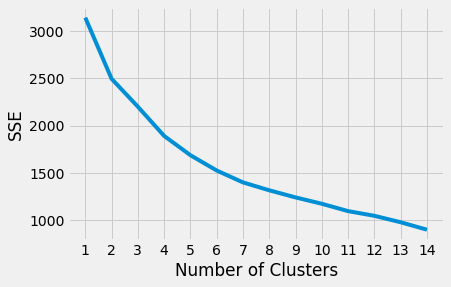

In [6]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [7]:
#use kneed package to help locate elbow
from kneed import KneeLocator
kl = KneeLocator(range(1, 15), sse, curve="convex", direction="decreasing")
kl.elbow

5

Based on the elbow method, I would choose to use 5 clusters.

In [8]:
#run k-means with 5 clusters and append cluster number to the original dataframe
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
df['k Means Cluster'] = labels


In [9]:
df['k Means Cluster'].value_counts()

0    338
2      7
3      2
4      1
1      1
Name: k Means Cluster, dtype: int64

Since most clusters have fewer than 5 properties, this will likely not be helpful.

Switch to DBScan 

In [10]:
from sklearn.cluster import DBSCAN
import sklearn.utils
sklearn.utils.check_random_state(1000)

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df['DB Cluster']=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

#A sample of clusters
df.head(5)

,PROPERTY TYPE,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,MLS#,LATITUDE,LONGITUDE,k Means Cluster,DB Cluster
0,Townhouse,845 Wescott Sq,Eagan,55123,349000,3,3,Eagan,1546,5445.000000,1994,5,250.0,6159156,44.833087,-93.129735,0,-1
1,Townhouse,18314 Gladden Ln,Lakeville,55044,425000,4,4,Lakeville,2290,1785.000000,2019,19,205.0,6153258,44.683365,-93.220157,0,-1
2,Single Family Residential,17904 Greenwich Way,Lakeville,55044,574900,4,3,Summers Creek,3194,4486.000000,2022,1,160.0,6164143,44.691318,-93.226815,0,-1
3,Single Family Residential,17908 Greenwich Way,Lakeville,55044,679900,5,3,Summers Creek,3611,4486.000000,2022,1,160.0,6163589,44.691269,-93.226611,0,-1
4,Townhouse,4837 Bisset Ln #8105,Inver Grove Heights,55076,280000,2,2,Inver Grove Heights,1524,26264.151515,2005,1,336.0,6164131,44.878561,-93.055997,0,-1


In [11]:
df['DB Cluster'].value_counts()

-1    324
 0     13
 1      6
 2      6
Name: DB Cluster, dtype: int64

DBSCAN determines the majority of points are outliers (a cluster label of -1), even playing with the eps parameter ranging from 0.5 up to 2, suggesting there is little clustering.

In [12]:
df = df.drop(['k Means Cluster','DB Cluster'],axis=1)
df.head()

,PROPERTY TYPE,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,MLS#,LATITUDE,LONGITUDE
0,Townhouse,845 Wescott Sq,Eagan,55123,349000,3,3,Eagan,1546,5445.000000,1994,5,250.0,6159156,44.833087,-93.129735
1,Townhouse,18314 Gladden Ln,Lakeville,55044,425000,4,4,Lakeville,2290,1785.000000,2019,19,205.0,6153258,44.683365,-93.220157
2,Single Family Residential,17904 Greenwich Way,Lakeville,55044,574900,4,3,Summers Creek,3194,4486.000000,2022,1,160.0,6164143,44.691318,-93.226815
3,Single Family Residential,17908 Greenwich Way,Lakeville,55044,679900,5,3,Summers Creek,3611,4486.000000,2022,1,160.0,6163589,44.691269,-93.226611
4,Townhouse,4837 Bisset Ln #8105,Inver Grove Heights,55076,280000,2,2,Inver Grove Heights,1524,26264.151515,2005,1,336.0,6164131,44.878561,-93.055997


My conclusion: clustering would not be beneficial in this data set. The clusters are too small (k-means) or most points are outliers (DBSCAN). Thus, I will proceed with a multiple regression without segmenting the data.